In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats
import scipy.integrate
from tqdm import tqdm

# II. Simulation of an arbitrary trading strategy

In [3]:
def generate_random_returns(mean, stddev, num_of_steps, num_of_simulations):
    return np.random.lognormal(mean=mean, sigma=stddev, size=(num_of_simulations, num_of_steps))

def get_prices_from_returns(returns):
    prices = returns.cumprod(axis=1)
    return np.insert(prices, 0, 1, axis=1)

### Backtesting

In [4]:
returns = generate_random_returns(0.0003, 0.012, 252, 100_000)
prices = get_prices_from_returns(returns)

position = (returns > 1).astype(int)
strategy_returns = (returns[:, 1:]-1) * position[:, :-1] + 1

buy_and_hold_sharpe = (returns.mean()-1)/returns.std() * 252**.5
strategy_sharpe = (strategy_returns.mean()-1)/strategy_returns.std() * 252**.5
print(f'Buy-and-hold Sharpe: {buy_and_hold_sharpe}')
print(f'Strategy Sharpe: {strategy_sharpe}')

Buy-and-hold Sharpe: 0.488018436226845
Strategy Sharpe: 0.3493160102916476


### A sample of the strategy

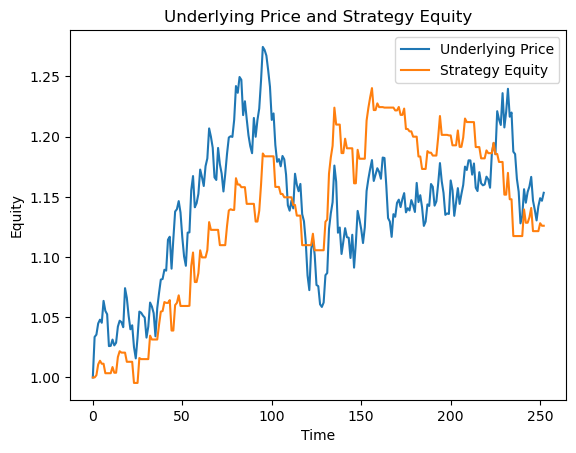

In [5]:
plt.plot(prices[0])
plt.plot(np.append([1, 1], strategy_returns[0].cumprod()))
plt.title('Underlying Price and Strategy Equity')
plt.legend(['Underlying Price', 'Strategy Equity'])
plt.xlabel('Time')
plt.ylabel('Equity')
plt.show()

# III. Options and their theoretical Sharpe Ratio

In [6]:
RISK_FREE_RATE = 0.00
ANNUAL_VOLATILITY = 0.012*252**.5
TIME_TO_MATURITY = 1
DAYS_IN_YEAR = 252
STOCK_PRICE = 1
EQUITY_RETURNS = 0.0003*252

In [7]:
def calculate_probability(current_price, start_price, risk_free_rate, volatility, time_elapsed):
    mu = math.log(start_price)+risk_free_rate*time_elapsed
    sigma = volatility*time_elapsed**.5
    return math.exp(-(math.log(current_price)-mu)**2/(2*sigma**2))/(current_price*sigma*math.sqrt(2*math.pi))

def calculate_delta(spot, strike, risk_free_rate, volatility, time_to_maturity):
    d1 = (np.log(spot/strike)+(risk_free_rate+volatility**2/2)*time_to_maturity)/(volatility*time_to_maturity**.5)
    return scipy.stats.norm.cdf(d1)

In [8]:
result = scipy.integrate.dblquad(
    lambda p, t: calculate_probability(p, STOCK_PRICE, EQUITY_RETURNS, ANNUAL_VOLATILITY, t) * calculate_delta(p, STOCK_PRICE, RISK_FREE_RATE, ANNUAL_VOLATILITY, TIME_TO_MATURITY-t),
    0, TIME_TO_MATURITY, 0, 10
)
expected_delta = result[0]/TIME_TO_MATURITY
print(result)

result = scipy.integrate.dblquad(
    lambda p, t: calculate_probability(p, STOCK_PRICE, EQUITY_RETURNS, ANNUAL_VOLATILITY, t) * calculate_delta(p, STOCK_PRICE, RISK_FREE_RATE, ANNUAL_VOLATILITY, TIME_TO_MATURITY-t)**2,
    0, TIME_TO_MATURITY, 0, 10
)
expected_squared_delta = result[0]/TIME_TO_MATURITY
print(result)

(0.5939661271069328, 1.4899916262283859e-08)
(0.4405169444296634, 1.4899895795236637e-08)


In [9]:
expected_return = math.exp(EQUITY_RETURNS/DAYS_IN_YEAR+(ANNUAL_VOLATILITY/DAYS_IN_YEAR**.5)**2/2) - 1
expected_squared_return = math.exp(2*(EQUITY_RETURNS/DAYS_IN_YEAR+(ANNUAL_VOLATILITY/DAYS_IN_YEAR**.5)**2)) - 2*math.exp(EQUITY_RETURNS/DAYS_IN_YEAR+(ANNUAL_VOLATILITY/DAYS_IN_YEAR**.5)**2/2) + 1

In [10]:
theoretical_sharpe_ratio = (expected_return-RISK_FREE_RATE)/math.sqrt(
    expected_squared_delta/expected_delta**2*(expected_squared_return-2*expected_return*RISK_FREE_RATE+RISK_FREE_RATE**2)
    -(expected_return**2-2*expected_return*RISK_FREE_RATE+RISK_FREE_RATE**2)
)
theoretical_sharpe_ratio*DAYS_IN_YEAR**.5

0.44025509477418023

# IV. Simulation of a call option

In [11]:
def black_scholes_model(spot, strike, risk_free_rate, volatility, time_to_maturity):
    if time_to_maturity == 0:
        return max(0, spot-strike)
    else:
        d1 = (np.log(spot/strike)+(risk_free_rate+volatility**2/2)*time_to_maturity)/(volatility*time_to_maturity**.5)
        d2 = d1-volatility*time_to_maturity**0.5
        return spot*scipy.stats.norm.cdf(d1) - strike*math.exp(-risk_free_rate*time_to_maturity)*scipy.stats.norm.cdf(d2)

In [12]:
returns = generate_random_returns(EQUITY_RETURNS/DAYS_IN_YEAR, ANNUAL_VOLATILITY/DAYS_IN_YEAR**.5, DAYS_IN_YEAR, 10000)
prices = get_prices_from_returns(returns)

option_value = []
for price_series in tqdm(prices):
    temp = []
    for i, p in enumerate(price_series):
        temp.append(black_scholes_model(p, 1, RISK_FREE_RATE, ANNUAL_VOLATILITY, TIME_TO_MATURITY-i/DAYS_IN_YEAR))
    option_value.append(temp)
option_value = np.array(option_value)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:36<00:00, 25.19it/s]


In [13]:
portfolio_value = option_value - option_value[:, [0]] + 1
portfolio_returns = portfolio_value[:, 1:] / portfolio_value[:, :-1] - 1
portfolio_returns.mean()/portfolio_returns.std()*DAYS_IN_YEAR**.5

0.43344869218172954

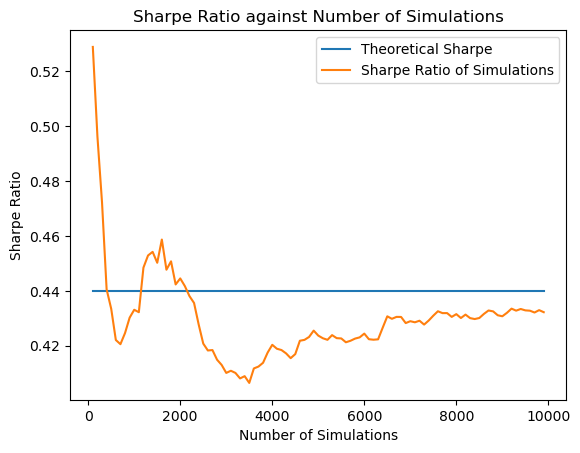

In [14]:
s = []
for i in range(100, portfolio_returns.shape[0], 100):
    s.append(portfolio_returns[:i].mean()/portfolio_returns[:i].std()*DAYS_IN_YEAR**.5)
plt.plot(range(100, portfolio_returns.shape[0], 100), [0.44]*len(s))
plt.plot(range(100, portfolio_returns.shape[0], 100), s)
plt.title('Sharpe Ratio against Number of Simulations')
plt.legend(['Theoretical Sharpe', 'Sharpe Ratio of Simulations'])
plt.xlabel('Number of Simulations')
plt.ylabel('Sharpe Ratio')
plt.show()

# V. Exceptions

In [15]:
def generate_random_returns_with_autocorrelation(alpha, mean, stddev, num_of_steps, num_of_simulations):
    returns = [np.random.normal(mean, stddev, num_of_simulations)]
    for _ in range(num_of_steps-1):
        returns.append(np.random.normal(mean, stddev, num_of_simulations)+alpha*returns[-1])
    returns = np.exp(returns).transpose()
    return returns

def backtest_alpha(alpha):
    returns = generate_random_returns_with_autocorrelation(alpha, EQUITY_RETURNS/DAYS_IN_YEAR, ANNUAL_VOLATILITY/DAYS_IN_YEAR**.5, DAYS_IN_YEAR, 1000)
    prices = get_prices_from_returns(returns)

    option_value = []
    for price_series in tqdm(prices):
        temp = []
        for i, p in enumerate(price_series):
            temp.append(black_scholes_model(p, 1, RISK_FREE_RATE, ANNUAL_VOLATILITY, TIME_TO_MATURITY-i/DAYS_IN_YEAR))
        option_value.append(temp)
    option_value = np.array(option_value)

    portfolio_value = option_value - option_value[:, [0]] + 1
    portfolio_returns = portfolio_value[:, 1:] / portfolio_value[:, :-1] - 1
    return portfolio_returns.mean()/portfolio_returns.std()*DAYS_IN_YEAR**.5, (returns.mean()-1)/returns.std()*DAYS_IN_YEAR**.5

In [16]:
result = {}
for alpha in np.arange(0, 0.22, 0.02):
    option_sharpe, buy_and_hold_sharpe = backtest_alpha(alpha)
    result[alpha] = {'option_sharpe': option_sharpe, 'buy_and_hold_sharpe': buy_and_hold_sharpe}
result = pd.DataFrame(result).transpose()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 23.95it/s]


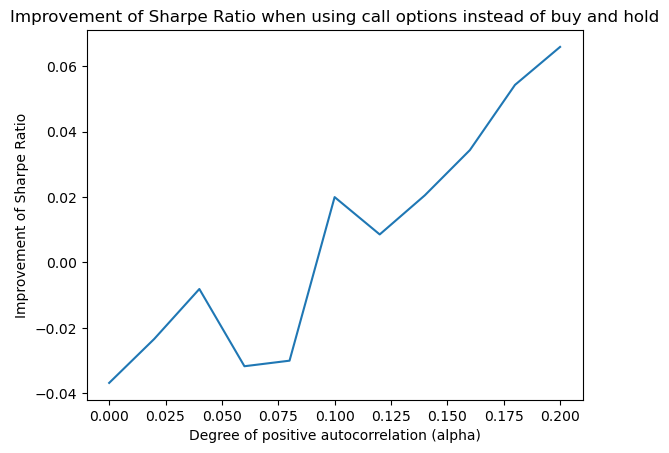

In [17]:
result['sharpe_improvement'] = result['option_sharpe'] - result['buy_and_hold_sharpe']
result['sharpe_improvement'].plot()
plt.title('Improvement of Sharpe Ratio when using call options instead of buy and hold')
plt.xlabel('Degree of positive autocorrelation (alpha)')
plt.ylabel('Improvement of Sharpe Ratio')
plt.show()